In [1]:
import re
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split

2024-04-13 19:12:05.934018: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 19:12:06.605144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
txt_file = 'data/kor_ballad_text.txt'
raw_corpus = []

with open(txt_file, 'r', encoding = 'utf-8') as f:
    raw = f.read().splitlines()
    raw_corpus.extend(raw)
print(len(raw_corpus))

401453


In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()                         #소문자 변경 후 양쪽 공백 제거
    sentence = re.sub(r"([?.!,¿]).,", r" \1 ", sentence)          #특수문자 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                 #여러 개의 공백이 붙어있으면 하나의 공백으로
    sentence = re.sub(r"[^a-zA-Z가-힣?!¿]+", " ", sentence)   #영어, 알파벳, ?, !, ¿ 제외 모두 공백으로
    sentence = sentence.strip()                                 #양쪽 공백 제거
    sentence = re.sub(r"\(.\)", " ", sentence)                  #괄호 제거
    sentence = '<start> ' + sentence + ' <end>'                 #start, end 추가
    return sentence

In [4]:
corpus = []
for sentence in raw_corpus:
    if len(sentence) == 0:
        continue
    if sentence[-1] == ':':
        continue
    if len(sentence)>150:
        continue

    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)

print(len(corpus))
print(corpus[:10])

193456
['<start> dearest darling my universe <end>', '<start> 날 데려가 줄래? <end>', '<start> 나의 이 가난한 상상력으론 <end>', '<start> 떠올릴 수 없는 곳으로 <end>', '<start> 저기 멀리 from earth to mars <end>', '<start> 꼭 같이 가줄래? <end>', '<start> 그곳이 어디든 오랜 외로움 <end>', '<start> 그 반대말을 찾아서 <end>', '<start> 어떤 실수로 <end>', '<start> 이토록 우리는 <end>']


In [5]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 30000, filters = ' ', oov_token = '<unk>')
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
    print('토크나이저: ', tokenizer, '\n', tensor)

    return tensor, tokenizer

In [6]:
tensor, tokenizer = tokenize(corpus)

토크나이저:  <keras.src.legacy.preprocessing.text.Tokenizer object at 0x7fcca8b60850> 
 [[   2    1 3113 ...    0    0    0]
 [   2    9 5536 ...    0    0    0]
 [   2   23   18 ...    0    0    0]
 ...
 [   2  418    1 ...    0    0    0]
 [   2  124 1094 ...    0    0    0]
 [   2 3884   41 ...    0    0    0]]


In [7]:
tensor.shape

(193456, 20)

In [8]:
for idx in tokenizer.index_word:
    print(idx, ':', tokenizer.index_word[idx])
    if idx>=20: break

1 : <unk>
2 : <start>
3 : <end>
4 : 내
5 : 난
6 : 그
7 : 수
8 : 널
9 : 날
10 : 내가
11 : 너를
12 : you
13 : 나
14 : i
15 : 그대
16 : 나를
17 : 다시
18 : 이
19 : 더
20 : 너의


In [9]:
#소스 문장과 타겟 문장으로 1차 분리
#tensor에서 마지막 토큰을 잘라내어 소스 문장을, 첫번째 start를 잘라내어 타겟 문장을 생성
#LSTM에서 many-to-many의 답을 얻을 것이므로 위와 같이 구성 <- ????
#이 과정을 통해 src_input과 tgt_input 길이 동일
src_input = tensor[:, :-1]      #start+sentence+end+padding n-1개
tgt_input = tensor[:, 1:]       #sentence+end+padding n개
print('텐서 길이: ', tensor.shape)
print('소스문장 길이: ', len(src_input[0]))
print('타겟문장 길이: ', len(tgt_input[0]))

텐서 길이:  (193456, 20)
소스문장 길이:  19
타겟문장 길이:  19


In [10]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 1234)
print('Source Train 길이: ', enc_train.shape)
print('Target Train 길이: ', dec_train.shape)
print('Source Test 길이: ', enc_val.shape)
print('Target Test 길이: ', dec_val.shape)

Source Train 길이:  (154764, 19)
Target Train 길이:  (154764, 19)
Source Test 길이:  (38692, 19)
Target Test 길이:  (38692, 19)


In [11]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epochs = len(src_input) // BATCH_SIZE
VOCAB_SIZE = tokenizer.num_words + 1

dataset_train = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder = True)

dataset_val = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset_val = dataset_val.shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder = True)

print(dataset_train)
print(dataset_val)

2024-04-13 19:12:31.516663: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 19:12:31.553627: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 19:12:31.553790: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

<_BatchDataset element_spec=(TensorSpec(shape=(256, 19), dtype=tf.int32, name=None), TensorSpec(shape=(256, 19), dtype=tf.int32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(256, 19), dtype=tf.int32, name=None), TensorSpec(shape=(256, 19), dtype=tf.int32, name=None))>


In [12]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)      #vocab_size로 입력되어서 그걸 embedding_size 만큼으로 표현할 것
        self.rnn_1 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.rnn_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.linear = tf.keras.layers.Dense(vocab_size)     #vocab_size로 줄여야 다음에 무슨 단어를 낼지에 대한 각 클래스 별 수치가 출력

    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)

        return out

In [13]:
embedding_size = 256    #word embedding 차원 수. 즉, 단어가 추상적으로 표현되는 크기 -> dataset의 shape과 같아야 하는거 아닌지???
hidden_size = 1024      #hidden state의 차원 수
model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)
model

<TextGenerator name=text_generator, built=False>

In [14]:
for src_sample, tgt_sample in dataset_train.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 19, 30001), dtype=float32, numpy=
array([[[ 4.96937893e-03, -4.52478649e-03, -3.42098880e-03, ...,
         -7.24693574e-03, -5.58525231e-03,  3.71861830e-03],
        [-1.07901916e-02,  8.49055313e-03,  2.97326304e-04, ...,
          1.42121166e-02, -7.18173524e-03,  2.70851236e-03],
        [-2.58796592e-03, -6.33713789e-03,  5.30695729e-03, ...,
          2.14936752e-02, -1.41912727e-02,  9.87642538e-03],
        ...,
        [ 5.87787554e-02,  4.56168409e-03,  1.06628105e-01, ...,
          4.18902673e-02,  7.78067065e-03, -2.12522154e-03],
        [ 2.94753946e-02,  8.95567462e-02, -3.27418707e-02, ...,
         -2.60822754e-02, -1.42874226e-01,  6.28621504e-02],
        [ 3.51511315e-02, -5.13749793e-02, -1.50419567e-02, ...,
         -1.83036667e-03, -4.38304385e-03, -7.44912401e-02]],

       [[ 4.96937893e-03, -4.52478649e-03, -3.42098880e-03, ...,
         -7.24693574e-03, -5.58525231e-03,  3.71861830e-03],
        [-7.77417375e-03, -3.30322469e-03, -2

In [15]:
model.summary()

Model: "text_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     7,680,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │    30,751,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,841,201 (159.61 MB)

 Trainable params: 41,841,201 (159.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

In [18]:
model.compile(loss = loss, optimizer = optimizer)
model.fit(dataset_train, epochs = 10)

Epoch 1/10


I0000 00:00:1713035567.991370  539059 service.cc:145] XLA service 0x33f1c440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713035567.991413  539059 service.cc:153]   StreamExecutor device (0): NVIDIA A16-16Q, Compute Capability 8.6
2024-04-13 19:12:48.036591: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-13 19:12:48.510170: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1713035570.582437  539119 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_61', 84 bytes spill stores, 84 bytes spill loads

I0000 00:00:1713035570.860137  539120 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_63', 84 bytes spill stores, 84 bytes spill loads

I0000 00:00:1713035571.9343

604/604 ━━━━━━━━━━━━━━━━━━━━ 162s 254ms/step - loss: 2.2447
Epoch 2/10
604/604 ━━━━━━━━━━━━━━━━━━━━ 154s 255ms/step - loss: 1.7489
Epoch 3/10
604/604 ━━━━━━━━━━━━━━━━━━━━ 155s 255ms/step - loss: 1.6384
Epoch 4/10
604/604 ━━━━━━━━━━━━━━━━━━━━ 155s 255ms/step - loss: 1.5710
Epoch 5/10
604/604 ━━━━━━━━━━━━━━━━━━━━ 155s 256ms/step - loss: 1.5129
Epoch 6/10
604/604 ━━━━━━━━━━━━━━━━━━━━ 155s 256ms/step - loss: 1.4504
Epoch 7/10
604/604 ━━━━━━━━━━━━━━━━━━━━ 155s 256ms/step - loss: 1.3816
Epoch 8/10
604/604 ━━━━━━━━━━━━━━━━━━━━ 155s 256ms/step - loss: 1.3023
Epoch 9/10
604/604 ━━━━━━━━━━━━━━━━━━━━ 155s 256ms/step - loss: 1.2211
Epoch 10/10
604/604 ━━━━━━━━━━━━━━━━━━━━ 155s 256ms/step - loss: 1.1404


In [19]:
model.save('rnn_kor_ballad.keras')
tf.saved_model.save(model, 'rnn_kor_ballad.tf')

INFO:tensorflow:Assets written to: rnn_kor_ballad.tf/assets


INFO:tensorflow:Assets written to: rnn_kor_ballad.tf/assets


In [20]:
def generate_text(model, tokenizer, init_sentence = '<start>', max_len = 30):
    #테스트를 위해 입력받은 init_sentence도 텐서 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype = tf.int64)
    end_token = tokenizer.word_index['<end>']

    #단어를 하나씩 예측해 문장 생성
    while True:
        #1. 입력받은 문장의 텐서 입력
        predict = model(test_tensor)
        #2. 예측된 값 중 가장 높은 확률인 word index를 출력
        predict_word = tf.argmax(tf.nn.softmax(predict, axis = -1), axis = -1)[:, -1]
        #3. 2에서 예측된 word index를 문장 뒤에 붙임
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis = 0)], axis = -1)
        #4. 모델이 <end>를 예측했거나 max_len에 도달하면 문장 생성을 마침
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ''
    #tokenizer를 활용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + ' '

    return generated

In [21]:
generate_text(model, tokenizer, init_sentence = '<start> i')

'<start> i m in madeleine love <end> '

In [22]:
generate_text(model, tokenizer, init_sentence = '<start> 나')

'<start> 나 지금 그대에게 가고있어요 <end> '

In [23]:
generate_text(model, tokenizer, init_sentence = '<start> 나', max_len = 50)

'<start> 나 지금 그대에게 가고있어요 <end> '

In [24]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑해')

'<start> 사랑해 <end> '

In [25]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑은')

'<start> 사랑은 상처받는 꿈일 뿐이야 <end> '

In [26]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑이')

'<start> 사랑이 지나가면 <end> '

ballad_소수빈-last chance  
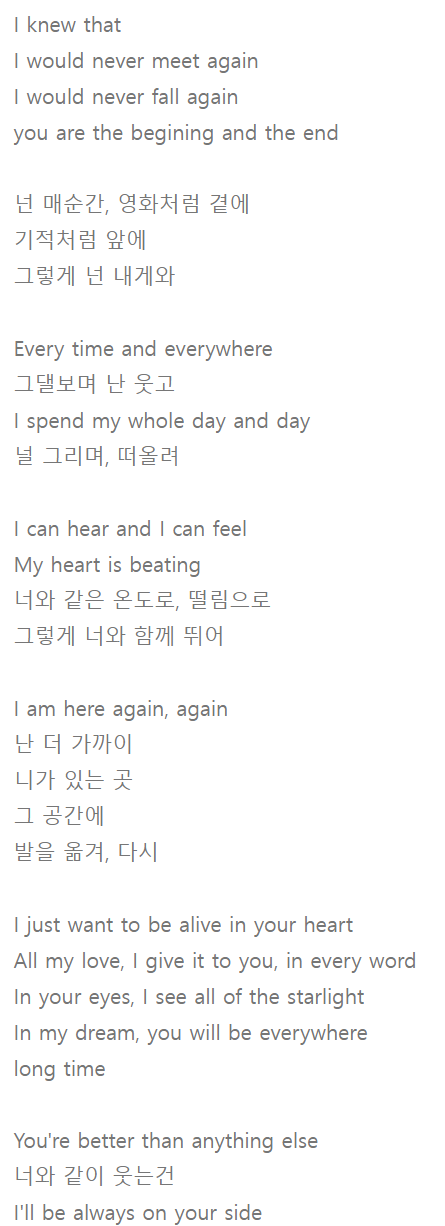

In [27]:
last_chance = ['i', '넌', '기적처럼', '그렇게', 'every', '그댈', '널', '너와', '난', '발을']
for word in last_chance:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> i m in madeleine love <end> 
<start> 넌 나의 blue <end> 
<start> 기적처럼 <end> 
<start> 그렇게 <unk> <end> 


<start> every day every night <end> 
<start> 그댈 사랑할수록 <end> 
<start> 널 사랑해 <end> 
<start> 너와 함께 걸어갈게 <end> 
<start> 난 너를 사랑해 <end> 
<start> 발을 맞춰 자라났나 봐 <end> 


all genre_임수-goood  
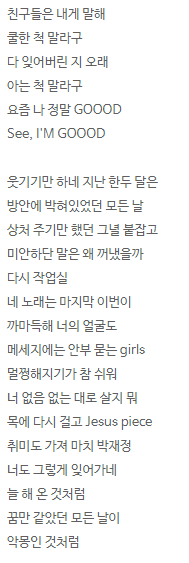

In [28]:
goood = ['친구들은', '쿨한', '다', '아는', '요즘', 'see', '웃기기만', '방안에', '상처', '미안하단']
for word in goood:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> 친구들은 <end> 
<start> <unk> <end> 
<start> 다 다 줄게 <end> 
<start> 아는 건 <end> 
<start> 요즘 내 일상이 <end> 


<start> see you again <end> 
<start> <unk> <end> 
<start> 방안에 <unk> <end> 
<start> 상처 할 일 없이 빗속으로 <end> 
<start> 미안하단 말도 못 하고 <end> 


: 